In [1]:
import gc
gc.collect()
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
torch.cuda.reset_peak_memory_stats()
#print(torch.cuda.memory_summary())

In [2]:
import json
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
from torchinfo import summary
from torch.utils.data import random_split, DataLoader
import torch.backends.cudnn as cudnn
from torch.utils.checkpoint import checkpoint

In [3]:
def load_data(directory="data"):
    data = {}
    required_cols = {"open", "high", "low", "close", "volume", "turnover"}
    for file in os.listdir(directory):
        if file.endswith("_15m_full.csv"):
            symbol = file.replace("_15m_full.csv", "")
            path = os.path.join(directory, file)
            try:
                df = pd.read_csv(
                    path,
                    parse_dates=["timestamp"],
                    date_format="%Y-%m-%d %H:%M:%S"
                ).set_index("timestamp")
                if required_cols.issubset(df.columns):
                    data[symbol] = df
            except Exception as e:
                print(f"Error loading {file}: {e}")
    return data

In [4]:
def load_sample_sizes(directory="samples"):
    sample_sizes = {}
    for file in os.listdir(directory):
        if file.startswith("samples_") and file.endswith(".csv"):
            feature = file.replace("samples_", "").replace(".csv", "")
            path = os.path.join(directory, file)
            try:
                sample_sizes[feature] = pd.read_csv(path, index_col=0)
            except Exception as e:
                print(f"Error loading {file}: {e}")
    return sample_sizes

In [5]:
class SampleDataset(Dataset):
    def __init__(
        self,
        data_dict: dict[str, pd.DataFrame],
        sample_sizes_dict: dict[str, pd.DataFrame],
        target_symbol: str,
        default_samples: int = 2500,
        future_steps: int = 100,
        features: tuple[str, ...] = ("open","high","low","close","volume","turnover"),
    ):
        # אורך חלונית דינמי
        sizes_df = sample_sizes_dict.get("close")
        if target_symbol in sizes_df.index:
            sample_len = int(sizes_df.loc[target_symbol, target_symbol]
                            ) if pd.notna(sizes_df.loc[target_symbol, target_symbol]) else default_samples
        else:
            sample_len = default_samples

        # סמלים עם מספיק נתונים
        valid = [s for s, df in data_dict.items()
                if len(df) >= sample_len + future_steps]
        if target_symbol not in valid:
            raise ValueError(f"Not enough data for {target_symbol}")

        # חתך משותף לכל הסמלים
        timeline = min(len(data_dict[s]) for s in valid)

        # שמירת פרמטרים
        self.sample_len = sample_len
        self.future_steps = future_steps
        self.target_idx = valid.index(target_symbol)
        self.close_idx = features.index("close")

        # בניית טנסורים ונרמול z‑score
        tensors = []
        for s in valid:
            arr = torch.stack([
                torch.tensor(data_dict[s][feat].values[:timeline], dtype=torch.float32)
                for feat in features
            ])  # [F, timeline]
            mean = arr.mean(dim=1, keepdim=True)
            std  = arr.std(dim=1, keepdim=True)
            tensors.append((arr - mean) / (std + 1e-6))
        self.data = torch.stack(tensors)  # [S, F, timeline]
        self.num_samples = timeline - (sample_len + future_steps)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # X: [S, F, L]
        x = self.data[:, :, idx : idx + self.sample_len]

        # close sequence עתידי
        close_seq = self.data[
            self.target_idx, self.close_idx,
            idx + self.sample_len : idx + self.sample_len + self.future_steps
        ]  # [future_steps]

        # לוג‑ריטורנס: log(p_t / p_{t-1})
        prev = close_seq[:-1]
        curr = close_seq[1:]
        log_ret = torch.log(curr / (prev + 1e-6))
        y = torch.cat([torch.tensor([0.], dtype=log_ret.dtype), log_ret], dim=0)  # [future_steps]

        return x, y

In [6]:
data_dict = load_data()
sample_sizes = load_sample_sizes()

In [7]:
dataset = SampleDataset(data_dict, sample_sizes, target_symbol="BTCUSDT")

In [8]:
print("Size of dataset:", len(dataset))

Size of dataset: 47725


In [9]:
train_n = int(0.75 * len(dataset))
test_n  = len(dataset) - train_n
train_ds, test_ds = random_split(dataset, [train_n, test_n])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

# דוגמה לבדיקה
x, y = next(iter(train_loader))
B, S, F, L = x.shape
future_steps = y.shape[1]
print(f"batch x: {x.shape}, y: {y.shape}")

batch x: torch.Size([32, 70, 6, 2500]), y: torch.Size([32, 100])


In [ ]:
class ConvTCNModel(nn.Module):
    def __init__(self, num_symbols, num_features, sample_len, future_steps):
        super().__init__()
        # extractor חותך לאורך ב־4 פעמים
        self.extractor = nn.Sequential(
            nn.Conv1d(num_features, 32, 3, stride=2, padding=1),
            nn.ELU(),
            nn.BatchNorm1d(32),
            nn.Conv1d(32, 64, 3, stride=2, padding=1),
            nn.ELU(),
            nn.BatchNorm1d(64),
        )
        self.seq_len = sample_len // 4

        # בלוק TCN
        self.tcn = nn.Sequential(
            nn.Conv1d(64, 64, 3, padding=1, dilation=1),
            nn.ELU(),
            nn.BatchNorm1d(64),
            nn.Conv1d(64, 64, 3, padding=1, dilation=1),
            nn.ELU(),
            nn.BatchNorm1d(64),
        )

        # Pool ו־FC
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc   = nn.Sequential(
            nn.Linear(64, 128),
            nn.ELU(),
            nn.LayerNorm(128),
            nn.Linear(128, future_steps),
        )

    def forward(self, x):
        # x: [B, S, F, L]
        B, S, F, L = x.size()
        z = x.view(B * S, F, L)
        z = self.extractor(z)      # [B*S,64,L/4]
        z = self.tcn(z)            # [B*S,64,L/4]
        z = z.view(B, S, 64, self.seq_len).mean(dim=1)  # [B,64,L/4]
        z = self.pool(z).squeeze(-1)                    # [B,64]
        return self.fc(z)                              # [B,future_steps]


In [11]:
def profit_loss(pred, actual):
    # maximize profit: negative mean profit
    returns = (actual[:,1:] - actual[:,:-1]) / actual[:,:-1]
    signals = torch.sign(pred[:,1:] - pred[:,:-1])
    profit = (signals * returns).sum(dim=1)
    return -profit.mean()

In [12]:
mse_fn = nn.MSELoss()
def mse_loss(pred, actual):
    return mse_fn(pred, actual)

def train_model(
    model,
    train_loader,
    val_loader,
    device,
    epochs=10,
    lr=1e-3,
    accumulation_steps=1,
    use_amp=True,
    use_checkpoint=False
):
    model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    scaler = GradScaler() if use_amp else None

    train_losses, val_losses = [], []

    for epoch in range(1, epochs + 1):
        # אימון
        model.train()
        running_train = 0.0
        optimizer.zero_grad()
        total_batches = 0

        for idx, (x, y) in enumerate(train_loader, start=1):
            x, y = x.to(device), y.to(device)
            y = torch.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)

            def forward_fn(inp):
                return model(inp)

            # forward + backward
            if use_checkpoint:
                if use_amp:
                    with autocast():
                        preds = checkpoint(forward_fn, x)
                        loss = mse_loss(preds, y)
                    scaler.scale(loss).backward()
                else:
                    preds = checkpoint(forward_fn, x)
                    loss = mse_loss(preds, y)
                    loss.backward()
            else:
                if use_amp:
                    with autocast():
                        preds = model(x)
                        loss = mse_loss(preds, y)
                    scaler.scale(loss).backward()
                else:
                    preds = model(x)
                    loss = mse_loss(preds, y)
                    loss.backward()

            # עדכון אקוחלצית
            if idx % accumulation_steps == 0:
                if use_amp:
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()
                optimizer.zero_grad()

            running_train += loss.item()
            total_batches += 1

        # step אחרון אם צריך
        if total_batches % accumulation_steps != 0:
            if use_amp:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()

        train_losses.append(running_train / total_batches)

        # ולידציה
        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                y_val = torch.nan_to_num(y_val, nan=0.0, posinf=0.0, neginf=0.0)

                if use_amp:
                    with autocast():
                        preds_val = model(x_val)
                        loss_val = mse_loss(preds_val, y_val)
                else:
                    preds_val = model(x_val)
                    loss_val = mse_loss(preds_val, y_val)

                running_val += loss_val.item()

        val_losses.append(running_val / len(val_loader))

        print(f"Epoch {epoch}/{epochs} — Train: {train_losses[-1]:.4f} — Val: {val_losses[-1]:.4f}")

    return model, train_losses, val_losses









In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
model = ConvTCNModel(num_symbols=S,num_features=F,sample_len=L,future_steps=future_steps,).to(device)
optimizer = Adam(model.parameters(), lr=0.001)

In [15]:
summary(model,input_size=x.shape,device=device)

Layer (type:depth-idx)                   Output Shape              Param #
ConvTCNModel                             [32, 100]                 --
├─Sequential: 1-1                        [2240, 64, 625]           --
│    └─Conv1d: 2-1                       [2240, 32, 1250]          608
│    └─ELU: 2-2                          [2240, 32, 1250]          --
│    └─BatchNorm1d: 2-3                  [2240, 32, 1250]          64
│    └─Conv1d: 2-4                       [2240, 64, 625]           6,208
│    └─ELU: 2-5                          [2240, 64, 625]           --
│    └─BatchNorm1d: 2-6                  [2240, 64, 625]           128
├─Sequential: 1-2                        [2240, 64, 625]           --
│    └─Conv1d: 2-7                       [2240, 64, 625]           12,352
│    └─ELU: 2-8                          [2240, 64, 625]           --
│    └─BatchNorm1d: 2-9                  [2240, 64, 625]           128
│    └─Conv1d: 2-10                      [2240, 64, 625]           12,352
│

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()
cudnn.benchmark = True  
with torch.no_grad():
    x, y = next(iter(train_loader))
    x, y = x.to(device), y.to(device)
    pred0 = model(x)
    print('pred:', pred0[0, :5])
    print('actual:', y[0, :5])
    print('mse_loss:', mse_fn(pred0, y).item())


pred: tensor([ 0.3962,  1.3288,  1.1553,  0.5854, -0.4520], device='cuda:0')
actual: tensor([ 0.0000,  0.0201,  0.0200, -0.0039, -0.0059], device='cuda:0')
mse_loss: 0.37673598527908325


In [17]:
model_BTC, train_losses, val_losses = train_model(model,train_loader, test_loader, device, epochs=35, lr=0.000001, accumulation_steps=4, use_amp=True)

Epoch 1/35 — Train: 0.3443 — Val: 0.2944
Epoch 2/35 — Train: 0.2602 — Val: 0.2253
Epoch 3/35 — Train: 0.2056 — Val: 0.1842
Epoch 4/35 — Train: 0.1714 — Val: 0.1551
Epoch 5/35 — Train: 0.1455 — Val: 0.1329
Epoch 6/35 — Train: 0.1253 — Val: 0.1144
Epoch 7/35 — Train: 0.1089 — Val: 0.0995
Epoch 8/35 — Train: 0.0951 — Val: 0.0863
Epoch 9/35 — Train: 0.0837 — Val: 0.0767
Epoch 10/35 — Train: 0.0740 — Val: 0.0681
Epoch 11/35 — Train: 0.0654 — Val: 0.0602
Epoch 12/35 — Train: 0.0579 — Val: 0.0531
Epoch 13/35 — Train: 0.0517 — Val: 0.0470
Epoch 14/35 — Train: 0.0459 — Val: 0.0416
Epoch 15/35 — Train: 0.0408 — Val: 0.0374
Epoch 16/35 — Train: 0.0364 — Val: 0.0331
Epoch 17/35 — Train: 0.0325 — Val: 0.0294
Epoch 18/35 — Train: 0.0291 — Val: 0.0273
Epoch 19/35 — Train: 0.0259 — Val: 0.0234
Epoch 20/35 — Train: 0.0232 — Val: 0.0209
Epoch 21/35 — Train: 0.0209 — Val: 0.0195
Epoch 22/35 — Train: 0.0187 — Val: 0.0176
Epoch 23/35 — Train: 0.0168 — Val: 0.0154
Epoch 24/35 — Train: 0.0151 — Val: 0.0144
E

In [18]:
def plot_loss(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure()
    plt.plot(epochs, train_losses, marker='o', label='Train Loss')
    plt.plot(epochs, val_losses,   marker='o', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

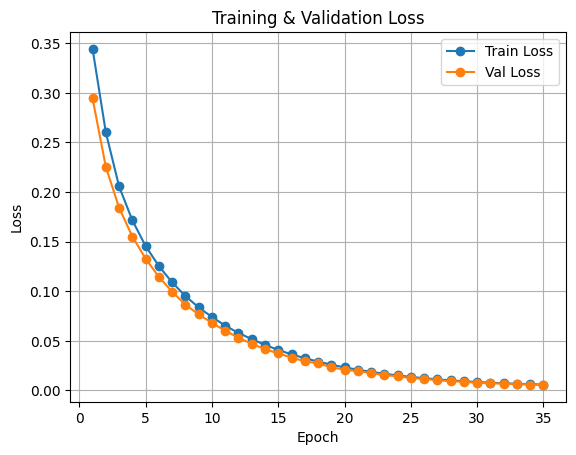

In [19]:
plot_loss(train_losses,val_losses)

In [20]:
params = {"B":B, "S":S, "F":F, "L":L, "future_steps":future_steps}
with open("BTC_model/shape_params.json","w") as f:
    json.dump(params, f)

In [21]:
torch.save(model_BTC.state_dict(), "BTC_model/model_BTC.pth")